## Use this script to load the Matlab simulated Ronchigram, resize, add noise, then pair with emittance and aberratio coeffs, and combine them into one single file
The 1024 px Ronchigram and aberration functions are too big, reshape the Ronchigrams to 128 px, add noise, then save it together with emittance from aberration function and the aberration coefficients. Both emittance and abr coeff are just numbers, should be very small in size.

In [1]:
%matplotlib nbagg

# import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import math
# import cv2
import glob
from random import randrange
from mpl_toolkits.axes_grid1 import make_axes_locatable

from PIL import Image, ImageEnhance 

## Process simulated Ronchigram with random cutoff aperture and noise
Cutoff aperture is added here, simulated Ronchigram from Matlab has no cutoff aperture.

In [18]:
# modified version, include different convergence angle and different noise level
# filelist = glob.glob('/home/chenyu/Desktop/ML_Alignment/AberrationMeasurement/RonchigramSimulation/ronchigram-matlab-master/CoarseCNN_data/*midAbr*30limit*.mat')
filelist = glob.glob('/home/chenyu/Desktop/ML_Alignment/AberrationMeasurement/RonchigramSimulation/ronchigram-matlab-master/CoarseCNN_data/*no1stOrder*.mat')
filelist.sort()
for i in range(len(filelist)):
    print(str(i) + '  ' + filelist[i])

0  /home/chenyu/Desktop/ML_Alignment/AberrationMeasurement/RonchigramSimulation/ronchigram-matlab-master/CoarseCNN_data/FullRandom_2ndOrder_no1stOrder_Nion_WhiteNoise_50limit_128px_x5000_1_norep.mat
1  /home/chenyu/Desktop/ML_Alignment/AberrationMeasurement/RonchigramSimulation/ronchigram-matlab-master/CoarseCNN_data/FullRandom_2ndOrder_no1stOrder_Nion_WhiteNoise_50limit_128px_x5000_2_norep.mat
2  /home/chenyu/Desktop/ML_Alignment/AberrationMeasurement/RonchigramSimulation/ronchigram-matlab-master/CoarseCNN_data/FullRandom_2ndOrder_no1stOrder_Nion_WhiteNoise_50limit_128px_x5000_3_norep.mat
3  /home/chenyu/Desktop/ML_Alignment/AberrationMeasurement/RonchigramSimulation/ronchigram-matlab-master/CoarseCNN_data/FullRandom_2ndOrder_no1stOrder_Nion_WhiteNoise_50limit_128px_x5000_4_norep.mat


In [19]:
# Load 10 simulated data, assign random cutoff aperture and noise level, aperture option is not in use
ronch = []
abr_coeff = []
emit = []
aperture = []
defocus = []
c3 = 0

# Acquisition condition for Ronchigrams used when simulating
simdim = 50
numpx = 128
current = 270 # current=30 within 20 mrad, current = 270 for 60 mrad aperture
emit_range = 45

# range in mrad for the cutoff aperture, generate list for aperture size in step size of 1 mrad
# Currently not in use, no limiting aperture in the current simulation
aperture_min = 25
aperture_max = 40
aperture_list = np.arange(aperture_min, aperture_max + 1)
apply_mask = False
# mask = mask_generator(temp2, simdim, 28)  # disable the mask generator if trying to save the whole Ronch

# list for dwell time used in simulation, the large number at the first place is used to simulate noiseless situation
# dtime_list = [32, 64, 128, 100000]
# dtime_list = [16, 32, 64, 100000]
# dtime_list = [2, 20, 200000]
dtime_list = [1000000]
index_list = [4,5,6,7,8]
index_list = [0,1,2,3]

for i in index_list:
    temp = sio.loadmat(filelist[i])
    abr_func = temp['chi0_final']
    for j in range(len(temp['aberration_final']['mag'][0])):
        dtime = dtime_list[randrange(len(dtime_list))]
        
        # append the aberration coefficient and emittance, the emittance is also calculated with 40 mrad cutoff range.
        abr_coeff.append(temp['aberration_final']['mag'][0][j])
        emit.append(np.sqrt(CalcEmittance_3(abr_func[:,:,j], simdim, emit_range)))  # calculate emittance within emit_range mrad

#         c3 = temp['aberration_final']['mag'][0][j][0][4]
#         print(emit[-1], c3)
        
        # single ronchigram with mask applied, mask is not currently in use
        temp2 = temp['ronch_final'][:,:,j]
        
        if apply_mask:
            ronch.append(reshape_noise_frame(temp2, numpx, current, dtime) * mask)
        else:
            ronch.append(reshape_noise_frame(temp2, numpx, current, dtime))
        
        # save the defocus
        defocus.append(abs(temp['aberration_final']['mag'][0][j][0][0]))
        
    print(filelist[i])

/home/chenyu/Desktop/ML_Alignment/AberrationMeasurement/RonchigramSimulation/ronchigram-matlab-master/CoarseCNN_data/FullRandom_2ndOrder_no1stOrder_Nion_WhiteNoise_50limit_128px_x5000_1_norep.mat
/home/chenyu/Desktop/ML_Alignment/AberrationMeasurement/RonchigramSimulation/ronchigram-matlab-master/CoarseCNN_data/FullRandom_2ndOrder_no1stOrder_Nion_WhiteNoise_50limit_128px_x5000_2_norep.mat
/home/chenyu/Desktop/ML_Alignment/AberrationMeasurement/RonchigramSimulation/ronchigram-matlab-master/CoarseCNN_data/FullRandom_2ndOrder_no1stOrder_Nion_WhiteNoise_50limit_128px_x5000_3_norep.mat
/home/chenyu/Desktop/ML_Alignment/AberrationMeasurement/RonchigramSimulation/ronchigram-matlab-master/CoarseCNN_data/FullRandom_2ndOrder_no1stOrder_Nion_WhiteNoise_50limit_128px_x5000_4_norep.mat


In [33]:
np.save('TrainingData_CoarseCNN/FullRandom_50mrad_defocus_whiteNoise_32pxGaussian_Noiseless_30pA_128pxRonch_x20000.npy',ronch)
np.save('TrainingData_CoarseCNN/FullRandom_50mrad_defocus_highAbr_whiteNoise_32pxGaussian_Noiseless_30pA_defocus_x20000',defocus)

In [25]:
np.save('TrainingData_CoarseCNN/FullRandom_50mrad_2ndOrder_no1stOrder_whiteNoise_32pxGaussian_Noiseless_45mradnewEmit_x20000.npy',emit)
np.save('TrainingData_CoarseCNN/FullRandom_50mrad_2ndOrder_no1stOrder_whiteNoise_32pxGaussian_Noiseless_128pxRonch_x20000.npy',ronch)
np.save('TrainingData_CoarseCNN/FullRandom_50mrad_2ndOrder_no1stOrder_whiteNoise_32pxGaussian_Noiseless_defocus_x20000',defocus)
np.save('TrainingData_CoarseCNN/FullRandom_50mrad_2ndOrder_no1stOrder_whiteNoise_32pxGaussian_Noiseless_abr_coeff_x20000.npy',abr_coeff)

In [14]:
del temp, abr_func

In [152]:
abr_list = []
for j in range(len(temp['aberration_final']['mag'][0])):
    abr_list.append(np.abs(temp['aberration_final']['mag'][0][j][0][5]))

ValueError: x and y must be the same size

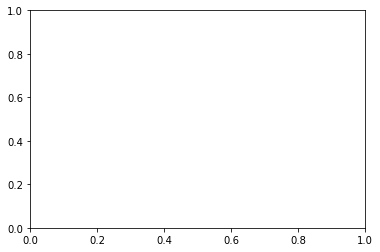

In [164]:
# np.save('FullRandom_25-40aperture_60limit_128px_multiNoise_30pA_convAngle_50000x.npy',aperture)
plt.scatter(np.asarray(defocus),np.asarray(abr_list), s=1)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Defocus (Angstrom)',fontsize=20)
plt.ylabel('$\epsilon$ (pm\u2022rad)',fontsize=20,rotation=90)
print(np.amax(defocus))

## Data Check
1. Visulize the whole index list, see if that is random
2. Visulize the ronchigram correspond to the smallest and largest emittance, check the match between Ronchigram and emit
3. Visulize the realtionship between emittance and single aberration coeff, check the match between emit and abr coeff

In [2]:
emit = np.load('TrainingData_CoarseCNN/FullRandom_50mrad_2ndOrder_whiteNoise_32pxGaussian_multiNoise_30pA_45mradnewEmit_x20000.npy')
ronch = np.load('TrainingData_CoarseCNN/FullRandom_50mrad_2ndOrder_whiteNoise_32pxGaussian_multiNoise_30pA_128pxRonch_x20000.npy')
defocus = np.load('TrainingData_CoarseCNN/FullRandom_50mrad_2ndOrder_whiteNoise_32pxGaussian_multiNoise_30pA_defocus_x20000.npy')

In [20]:
sort_idx = np.argsort(emit)
print(np.amin(emit))
print(np.amax(emit))

0.0036416371594670347
104.59580375565358


In [21]:
sort_idx = np.argsort(defocus)
print(np.amin(defocus))
print(np.amax(defocus))

0.0001006621087710156
49.99722085901597


In [22]:
label1 = emit / np.amax(emit)
label2 = defocus / np.amax(defocus)
label = (label1 + label2)/2
sort_idx = np.argsort(label1)

<IPython.core.display.Javascript object>


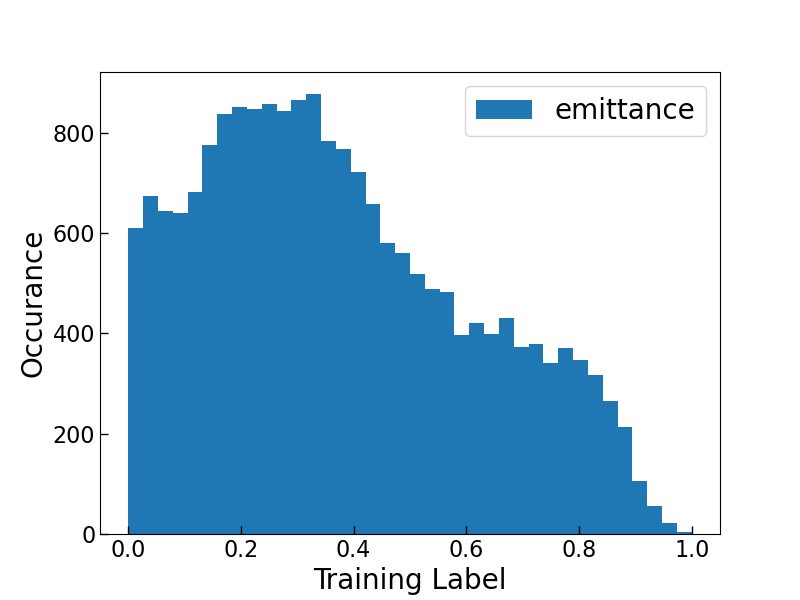

In [24]:
fig = plt.figure(figsize = [8,6])
ax = fig.add_subplot()
ax.hist(label1, bins='auto', label = 'emittance')  # arguments are passed to np.histogram
# plt.title("Emittance Histogram")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Training Label', fontsize = 20)
# plt.xlabel('Normalzied $\epsilon$(pm\u2022rad)',fontsize=20)
plt.ylabel('Occurance',fontsize=20,rotation=90)
ax.tick_params(direction='in', length=6, width=1)

# ax.hist(label, bins='auto', label = 'emittance + defocus')  # arguments are passed to np.histogram
plt.legend(fontsize = 20)

<IPython.core.display.Javascript object>


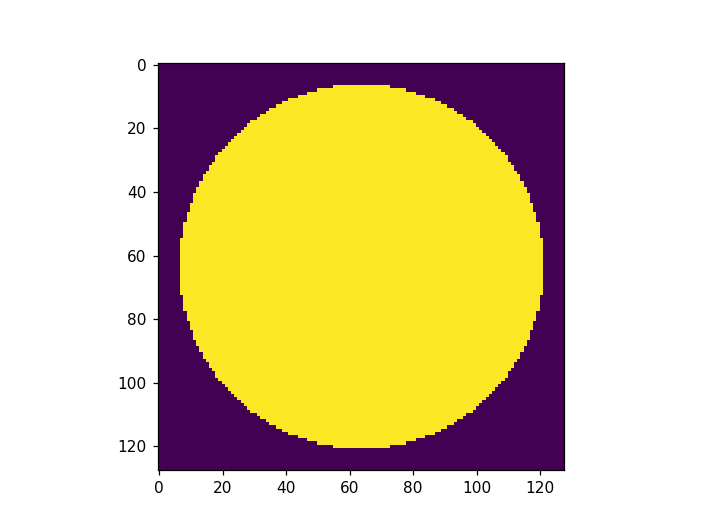

In [18]:
mask = aperture_generator(128, 50, 45)
plt.imshow(mask)

<IPython.core.display.Javascript object>


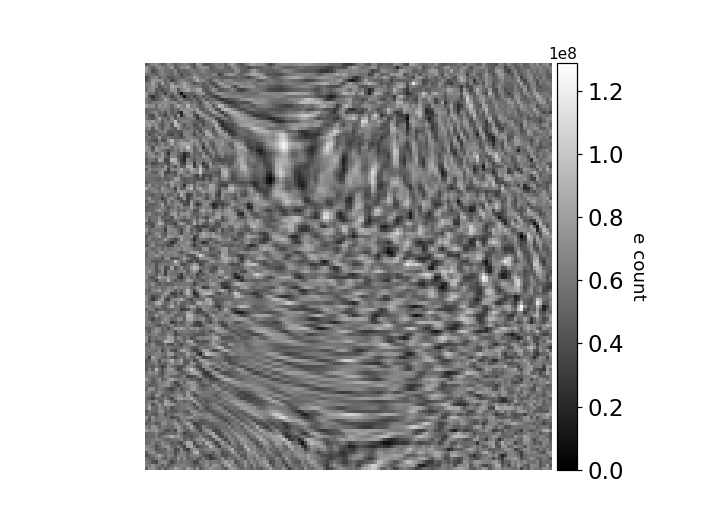

Emittance:0.18659288409155148
Defocus: 0.07833194760596825
Total Label: 0.13246241584875987


In [30]:
ax = plt.subplot(111)
idx = 9000

frame = ronch[sort_idx[idx]].astype('float')
# frame = scale_range(frame, 0, 1)

# frame = frame * 1.5
# frame[frame > 1] = 1
im = plt.imshow(frame, cmap='gray')

plt.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=15)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('e count',fontsize = 12, rotation=270)
print("Emittance:" + str(label1[sort_idx[idx]]))
print("Defocus: "+ str(label2[sort_idx[idx]]))
print("Total Label: " + str(label[sort_idx[idx]]))

## Check the data after ImageDataGenerator

In [8]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [52]:
x_train_list = []
y_train_list = []
for i in range(19000,20000):
    frame = scale_range(ronch[sort_idx[i]].astype('float'), 0, 1)
    frame = frame * mask
    new_channel = np.zeros(frame.shape)
    img_stack = np.dstack((frame, new_channel, new_channel))
    x_train_list.append(img_stack)
    y_train_list.append(label[sort_idx[i]])
x_train = np.concatenate([arr[np.newaxis] for arr in x_train_list])
y_train = np.asarray(y_train_list,dtype=np.float32)

In [56]:
x_train.shape

(1000, 128, 128, 3)

In [63]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    width_shift_range=0.0,
    height_shift_range=0.0,
    zoom_range=0.0,
    shear_range=0.0)

datagen.fit(x_train)
generator = datagen.flow(
    x_train,
    y_train,
    batch_size=100,
    shuffle=False)
temp = generator.next()
labels = temp[1]
temp = np.asarray(temp[0])

<IPython.core.display.Javascript object>


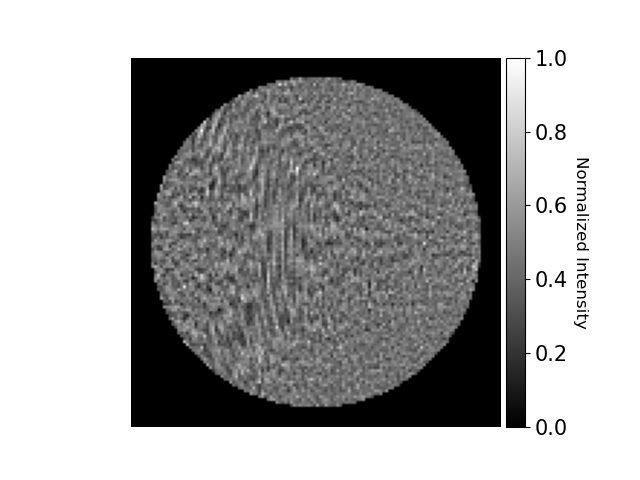

Total Label: 0.721447


In [65]:
ax = plt.subplot(111)
idx = 40
im = plt.imshow(temp[idx,:,:,0] * mask, cmap='gray')
# im = plt.imshow(x_train[idx][:,:,0] * mask, cmap='gray')

plt.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=15)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Normalized Intensity',fontsize = 12, rotation=270)
print("Total Label: " + str(y_train[idx]))

<IPython.core.display.Javascript object>


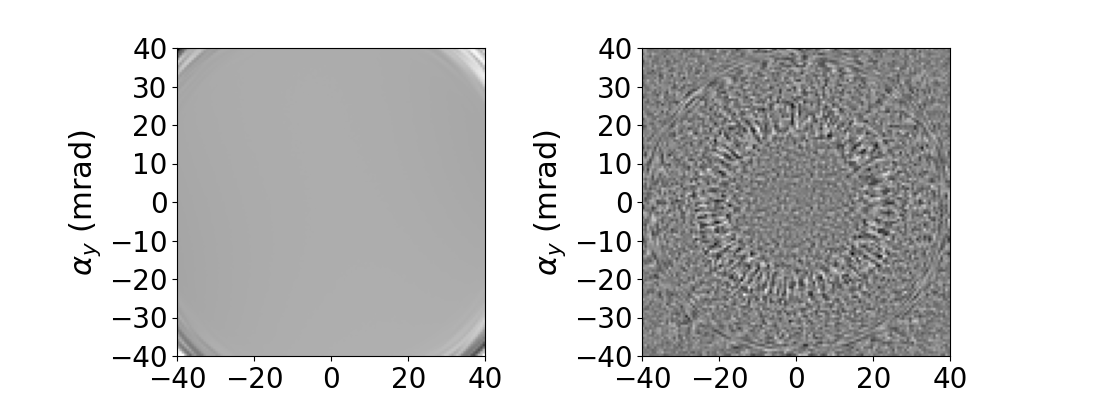

0.01644040913382367
0.4833227588149485
6.857789194199143e-05
State 2:
146.89489499708708
14943.691737740208
0.9669302554888048


In [156]:
# show examples of Ronchigrams with minimum and maximum emittance
low_idx = 0
plt.figure(figsize=[11,4])
plt.subplot(121)
plt.imshow(ronch[sort_idx[low_idx]], extent = [-simdim, simdim, -simdim, simdim], cmap='gray')
plt.xlabel(r"$\alpha_x \ \mathrm{(mrad)}$",fontsize=22)
plt.ylabel(r"$\alpha_y \ \mathrm{(mrad)}$",fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.colorbar()
print(emit[sort_idx[low_idx]])
print(defocus[sort_idx[low_idx]])
print(label[sort_idx[low_idx]])

plt.subplot(122)    
high_idx = -1
plt.imshow(ronch[sort_idx[high_idx]], extent = [-simdim, simdim, -simdim, simdim], cmap='gray')
plt.xlabel(r"$\alpha_x \ \mathrm{(mrad)}$",fontsize=22)
plt.ylabel(r"$\alpha_y \ \mathrm{(mrad)}$",fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()
print('State 2:')
print(emit[sort_idx[high_idx]])
print(defocus[sort_idx[high_idx]])
print(label[sort_idx[high_idx]])

## Aux functions

In [3]:
# Latest function that calculate emittance from determinant of covariance matrix
def CalcEmittance_3(abr, simdim, ap_size):

    imdim = abr.shape[0]
    px_size = simdim / (imdim/2) # pixel size in mrad
    px_size = px_size / 1000 # pixel size in rad

    abr_gradient = np.gradient(abr)
    # Divide by pixel size
    abr_gradient[0], abr_gradient[1] = abr_gradient[0] / px_size, abr_gradient[1] / px_size
    abr_gradient[0] = abr_gradient[0] * 1.97 / 2 / 3.14  # multiply by lambda/2pi to get real space coordinate in pm
    abr_gradient[1] = abr_gradient[1] * 1.97 / 2 / 3.14

    x = np.linspace(-simdim / 1000, simdim / 1000, imdim)
    y = np.linspace(-simdim / 1000, simdim / 1000, imdim)
    ax, ay = np.meshgrid(x, y)

    apt_mask = np.sqrt(ax*ax + ay*ay) < (ap_size / 1000) # aperture mask
    idx = (apt_mask != 0)
    
    # flatten x, y, ax, ay matrix and build covariance matrix
    idx = idx.flatten()
    ax = ax.flatten()[idx]
    ay = ay.flatten()[idx]
    x = abr_gradient[0].flatten()[idx]
    y = abr_gradient[1].flatten()[idx]

    cov_mat = np.cov([x,ax,y,ay])
    # return square root of determinant, which is the emittance in the 4D phase space
    return np.sqrt(np.linalg.det(cov_mat))

In [4]:
# Function to resample input array (arr) to new_shape, only work when the new shape is integer times smaller than original 
# array.
def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

In [5]:
def reshape_noise(arr, side_length, current, dtime):
    # optional: normalize the rochigrams, resample to 128x128 px, then add noise
    arr_reshape = np.zeros((side_length,side_length,arr.shape[2]))
    for i in range(arr.shape[2]):
        temp = arr[:,:,i]
        temp = rebin(temp,[side_length, side_length])
        temp = temp / np.sum(temp)
        temp = temp * current * dtime / 1.6 * 10000   # convert to number of electrons
        temp = np.random.poisson(temp)
        arr_reshape[:,:,i] = temp
    return arr_reshape

In [6]:
def reshape_noise_frame(frame, side_length, current, dtime):
# reshape and add noise for a single frame
    temp = rebin(frame,[side_length, side_length])
    # for new simulation with antialiasing, need to subtract background, contrast very small
    temp_sum = np.sum(temp)
    temp = temp - np.amin(temp) # get minimum intensity to zero
    temp = temp / np.sum(temp) * temp_sum # rescale to get same sum as before
    # No need to normalize if the input data is already normalized
#     temp = temp / np.sum(temp)
    temp[temp<0] = 0
    temp = temp * current * dtime / 1.6 * 10000   # convert to number of electrons
    temp = np.random.poisson(temp)
    return temp

In [7]:
def mask_generator(stack, simdim, ap_size):
    imdim = stack.shape[0]
    x = np.linspace(-simdim/1000, simdim/1000, imdim)
    y = np.linspace(-simdim/1000, simdim/1000, imdim)
    xv, yv = np.meshgrid(x, y)
    apt_mask = mask = np.sqrt(xv*xv + yv*yv) < ap_size/1000 # aperture mask
    return apt_mask

In [8]:
def pi_4_radius(probe, simdim):
    probe_binary = np.abs(probe) > math.pi/4
    radius = simdim # start with the maximum radius
    mask = mask_generator(probe, simdim, radius)
    overlap = np.sum(probe_binary * mask)
    while overlap > 0:
        radius = radius - 1
        mask = mask_generator(probe, simdim, radius)
        overlap = np.sum(probe_binary * mask)
    return radius

In [9]:
def PhaseDiff(probe, simdim, ap_size):
    mask = mask_generator(probe, simdim, ap_size)
    probe_mask = probe * mask
    return np.amax(np.abs(probe_mask)), np.sum(np.abs(probe_mask)) / np.sum(mask)

In [10]:
def aperture_generator(px_size, simdim, ap_size):
    x = np.linspace(-simdim, simdim, px_size)
    y = np.linspace(-simdim, simdim, px_size)
    xv, yv = np.meshgrid(x, y)
    apt_mask = mask = np.sqrt(xv*xv + yv*yv) < ap_size # aperture mask
    return apt_mask

In [11]:
def scale_range (input, min, max):
    input += -(np.min(input))
    input /= np.max(input) / (max - min)
    input += min
    return input 

## Plot the relationship between emittance and other conventional metrics

In [21]:
# Load 10 simulated data pair with varying defocus and A1, other aberrations fixed at zero
ronch = []
abr_coeff = []
emit = []
emit_new = []
emit_old = []
simdim = 40
emit_range = 40
current = 30
c3 = []

i = 0
temp = sio.loadmat(filelist[i])
abr_func = temp['chi0_final']
for j in range(len(temp['aberration_final']['mag'][0])):
    abr_coeff.append(temp['aberration_final']['mag'][0][j])
    emit_new.append(CalcEmittance_3(abr_func[:,:,j], simdim, emit_range))
    ronch.append(reshape_noise_frame(temp['ronch_final'][:,:,j],128, current, 10000))
#     emit_old.append(CalcEmittance_new(abr_func[:,:,j], simdim, emit_range))

NameError: name 'CalcEmittance_new' is not defined

<IPython.core.display.Javascript object>


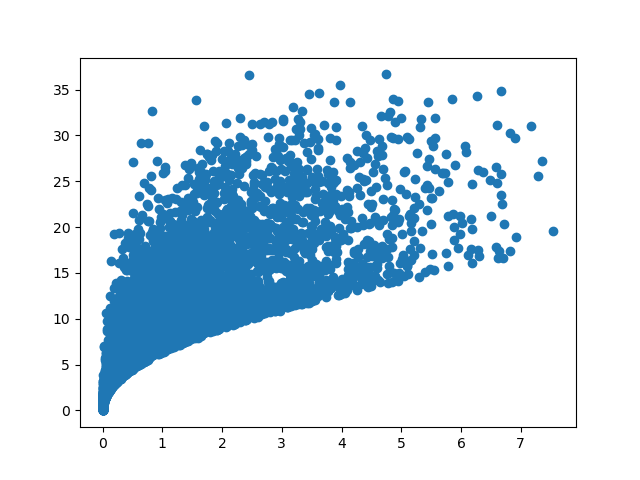

In [121]:
plt.scatter(emit_new, emit_old)

In [42]:
temp['aberration_final']['mag'][0][10][0][3]

3.1678306632429796

In [50]:
# pi/4 radius
pi_4 = []
max_phasediff = []
mean_phasediff = []
c3 = []
for i in range(abr_func.shape[-1]):
    pi_4.append(pi_4_radius(abr_func[:,:,i], simdim))
    results = PhaseDiff(abr_func[:,:,i], simdim, 40)
    max_phasediff.append(results[0])
    mean_phasediff.append(results[1])
    c3.append(abs(temp['aberration_final']['mag'][0][i][0][3]))

<IPython.core.display.Javascript object>


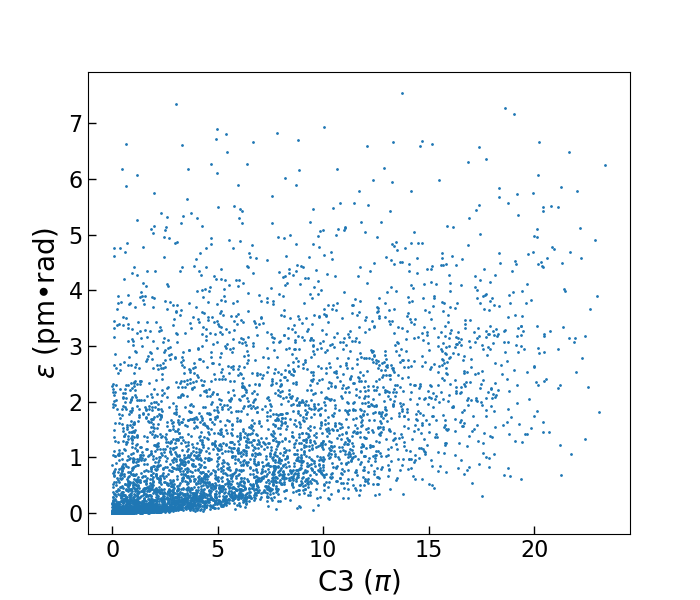

In [52]:
# Relationship between log emittance square and max phase difference
fig = plt.figure(figsize=[7,6])
ax = fig.add_subplot()
ax.scatter(np.asarray(c3), emit,s=1)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('C3 ($\pi$)',fontsize=20)
plt.ylabel('$\epsilon$ (pm$\u2022$rad)',fontsize=20,rotation=90)
ax.tick_params(direction='in', length=6, width=1)

<IPython.core.display.Javascript object>


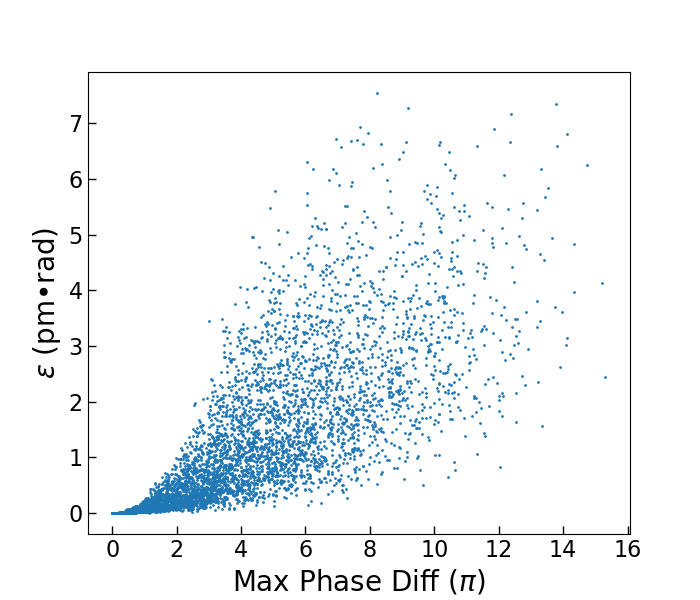

In [30]:
# Relationship between log emittance square and max phase difference
fig = plt.figure(figsize=[7,6])
ax = fig.add_subplot()
ax.scatter(np.asarray(max_phasediff)/math.pi, emit,s=1)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Max Phase Diff ($\pi$)',fontsize=20)
plt.ylabel('$\epsilon$ (pm$\u2022$rad)',fontsize=20,rotation=90)
ax.tick_params(direction='in', length=6, width=1)

<IPython.core.display.Javascript object>


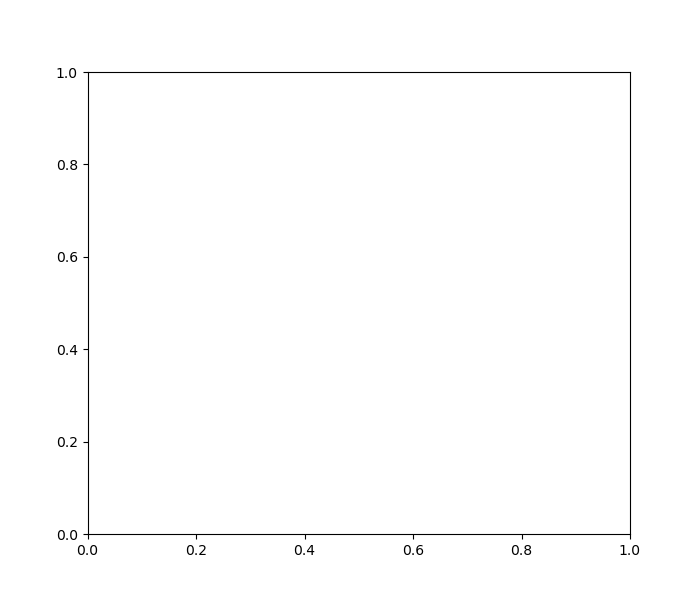

TypeError: list indices must be integers or slices, not tuple

In [32]:
# Relationship between log emittance square and max phase difference
# Zoomed in for low emittance part
emit_new = np.asarray(emit_new)
max_phasediff = np.asarray(max_phasediff)
idx = np.where(emit_new < 0.2)

fig = plt.figure(figsize=[7,6])
ax = fig.add_subplot()
ax.scatter(np.asarray(max_phasediff[idx])/math.pi, emit[idx] ,s=1.5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim([0,3])
plt.xlabel('Max Phase Diff ($\pi$)',fontsize=20)
plt.ylabel('$\epsilon$ (pm$\u2022$rad)',fontsize=20,rotation=90)
ax.tick_params(direction='in', length=6, width=1)

<IPython.core.display.Javascript object>


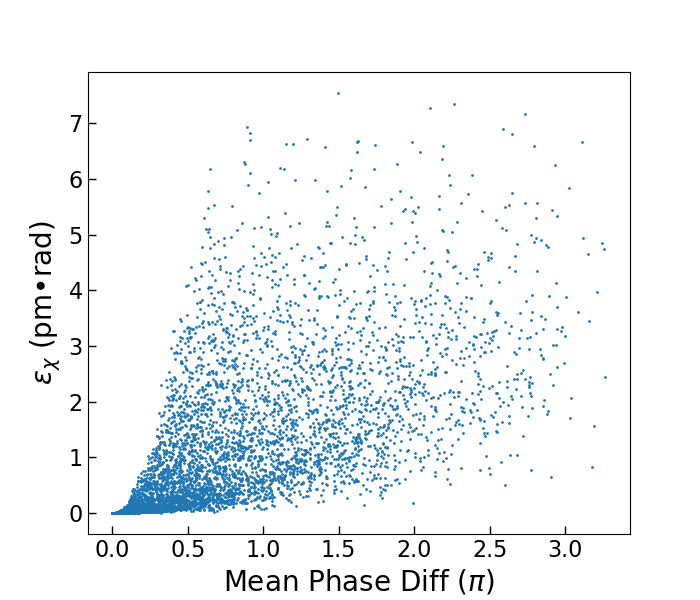

In [33]:
# Relationship between log emittance square and mean phase difference
fig = plt.figure(figsize=[7,6])
ax = fig.add_subplot()
plt.scatter(np.asarray(mean_phasediff)/math.pi, np.asarray(emit),s=1)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Mean Phase Diff ($\pi$)',fontsize=20)
plt.ylabel('$\epsilon_\chi$ (pm$\u2022$rad)',fontsize=20,rotation=90)
plt.tick_params(direction='in', length=6, width=1)

<IPython.core.display.Javascript object>


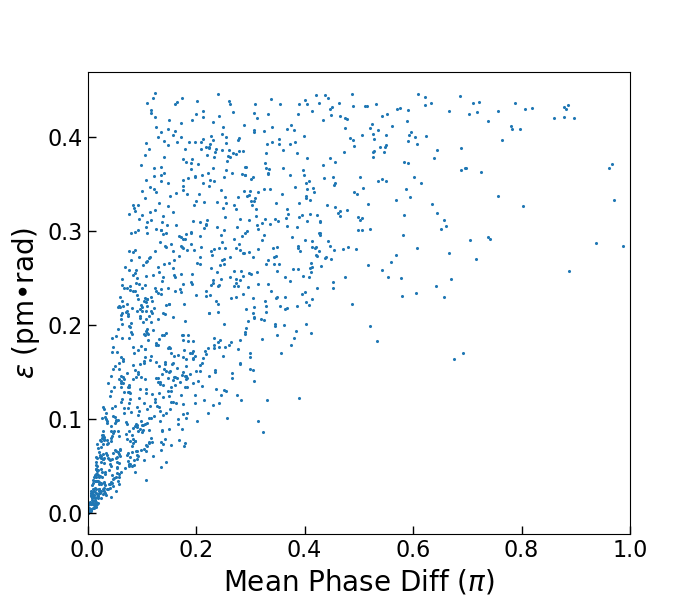

In [116]:
# Relationship between log emittance square and mean phase difference
fig = plt.figure(figsize=[7,6])
emit = np.asarray(emit)
mean_phasediff = np.asarray(mean_phasediff)
idx = np.where(emit_new < 0.2)

ax = fig.add_subplot()
ax.scatter(np.asarray(mean_phasediff[idx])/math.pi, np.sqrt(emit_new[idx]),s=1.5)
plt.xlim([0,1])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Mean Phase Diff ($\pi$)',fontsize=20)
plt.ylabel('$\epsilon$ (pm$\u2022$rad)',fontsize=20,rotation=90)
ax.tick_params(direction='in', length=6, width=1)

<IPython.core.display.Javascript object>


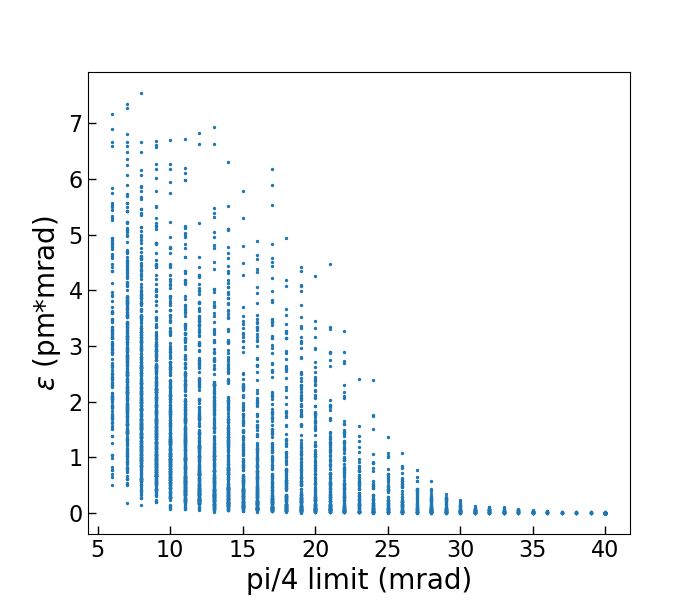

In [34]:
# Relationship between log emittance square and pi/4 radius
fig = plt.figure(figsize=[7,6])
ax = fig.add_subplot()
ax.scatter(pi_4, emit,s=2)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('pi/4 limit (mrad)',fontsize=20)
plt.ylabel('$\epsilon$ (pm*mrad)',fontsize=20,rotation=90)
ax.tick_params(direction='in', length=6, width=1)

In [47]:
np.save('NoAperture_validation/FullRandom_NoAperture_60limit_1us_pi_4limit_x5000_validation.npy',pi_4)
np.save('NoAperture_validation/FullRandom_NoAperture_60limit_1us_maxPhaseDiff_x5000_validation.npy',max_phasediff)
np.save('NoAperture_validation/FullRandom_NoAperture_60limit_1us_meanPhaseDiff_x5000_validation.npy',mean_phasediff)

## Check contrast in Matlab and GPT simulation

In [5]:
emit = np.load('TrainingData_CoarseCNN/FullRandom_NoAperture_C5_negC1_whiteNoise_60limit_multiNoise_30pA_emit_x10000.npy')
ronch = np.load('TrainingData_CoarseCNN/FullRandom_NoAperture_C5_negC1_whiteNoise_60limit_multiNoise_30pA_128pxRonch_x10000.npy')
defocus = np.load('TrainingData_CoarseCNN/FullRandom_NoAperture_C5_negC1_whiteNoise_60limit_multiNoise_30pA_defocus_x10000.npy')
ronch_scaled = ronch * 0
ronch_scaled = ronch_scaled.astype('float')
for i in range(10000):
    frame = scale_range(ronch[i,:,:].astype('float'),0, 1)
    ronch_scaled[i,:,:] = frame

0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1


<IPython.core.display.Javascript object>


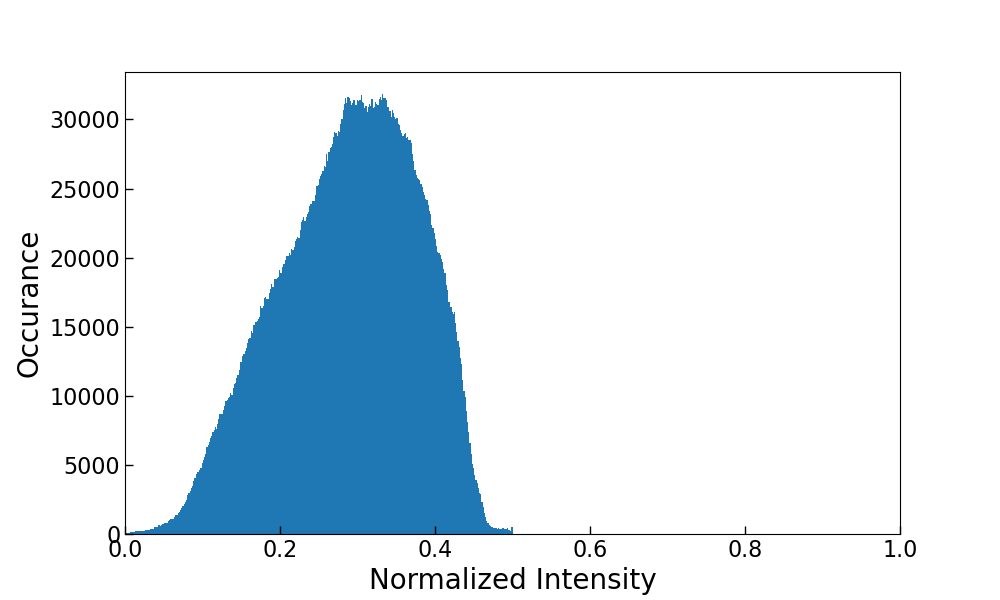

In [98]:
# GPTronch.shape
for i in range(GPTronch.shape[0]):
    frame = GPTronch[i,:,:]
    frame = frame/2
    GPTronch[i,:,:] = frame
fig = plt.figure(figsize = [10,6])
ax = fig.add_subplot()
ax.hist(np.ndarray.flatten(GPTronch), bins='auto')  # arguments are passed to np.histogram
# plt.title("Emittance Histogram")
plt.xticks(fontsize=16)
plt.xlim([0,1])
plt.yticks(fontsize=16)
plt.xlabel('Normalized Intensity',fontsize=20)
plt.ylabel('Occurance',fontsize=20,rotation=90)
ax.tick_params(direction='in', length=6, width=1)

## Test the relationship between emittance and rotation
Test with a series of Ronchigrams simulated with A1=100 nm as the only aberration and random rotation angle.
Results suggest that emittance has very weak dependence on the rotation angle.

In [38]:
# modified version, include different convergence angle and different noise level
filelist = glob.glob('/home/chenyu/Desktop/ML_Alignment/AberrationMeasurement/RonchigramSimulation/ronchigram-matlab-master/CoarseCNN_data/B2=3000nm*.mat')
filelist

['/home/chenyu/Desktop/ML_Alignment/AberrationMeasurement/RonchigramSimulation/ronchigram-matlab-master/CoarseCNN_data/B2=3000nm_rotationTest.mat']

In [39]:
# Load 10 simulated data, assign random cutoff aperture and noise level, aperture option is not in use
ronch = []
abr_angle = []
emit = []
aperture = []
defocus = []

# Acquisition condition for Ronchigrams used when simulating
simdim = 40
numpx = 128
current = 150 # current=30 for 70um aperture, current = 138 for 150 aperture
emit_range = 40
dtime_list = [100000]

temp = sio.loadmat(filelist[0])
abr_func = temp['chi0_final']
for j in range(len(temp['aberration_final']['mag'][0])):

    # append the aberration coefficient and emittance, the emittance is also calculated with 40 mrad cutoff range.
    abr_angle.append(temp['aberration_final']['angle'][0][j])
    emit.append(CalcEmittance_new(abr_func[:,:,j], simdim, emit_range))  # calculate emittance within emit_range mrad
    temp2 = temp['ronch_final'][:,:,j]
    dtime = dtime_list[randrange(len(dtime_list))]
    ronch.append(reshape_noise_frame(temp2, numpx, current, dtime))

In [40]:
np.save('TrainingData_CoarseCNN/B2=3um_rotationTest_emittance.npy',emit)
np.save('TrainingData_CoarseCNN/B2=3um_rotationTest_128pxRonch.npy',ronch)

In [41]:
abr_list = []
for j in range(len(temp['aberration_final']['mag'][0])):
    abr_list.append(np.abs(temp['aberration_final']['angle'][0][j][0][2]))

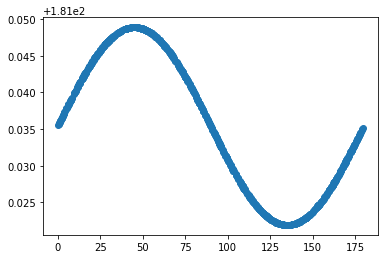

In [42]:
plt.scatter(abr_list, emit)

## Emittance with Jacobian determinant included
Turned out not necessary, see page 51 of my notebook for discussion of how to derive Paul's expression of emittance, which is actually correct.

In [249]:
abr = abr_func[:,:,500]
simdim = 60
emit_range = 40
imdim = abr.shape[0]
px_size = simdim/(imdim/2)/1000 # px size in rad

# calculate the gradient of aberration in unit of [1/rad]
# abr_gradient[0] is the gradient along dimension 1
# abr_gradient are two matrices along x and y, check whether rotated here!
abr_gradient = np.gradient(abr)
abr_gradient[0], abr_gradient[1] = abr_gradient[0]/px_size, abr_gradient[1]/px_size  # gradient normalized by pixel size

# Calculate the four elements of Jacobian matrix and the determinant for each pixel in reciprocal space
# do not need to normalize by pixel size again here?
# Jdet tells how much (x,y) changes when (kx, ky) change by 1 mrad^2
J11 = np.gradient(abr_gradient[1])[1]/px_size # how much x change in \lambda/2\pi when kx change by 1 mrad
J12 = np.gradient(abr_gradient[1])[0]/px_size
J21 = np.gradient(abr_gradient[0])[1]/px_size
J22 = np.gradient(abr_gradient[0])[0]/px_size
Jdet = J11*J22-J12*J21

# Calculate the Jacobian matrix for the integral over both real space and reciprocal space
# how much volume in (x,y,kx,ky) change for unit area in (kx,ky)
J_11 = (J11*J11 + J21*J21)
J_12 = (J11*J12 + J21*J22) 
J_22 = (J12*J12 + J22*J22)
J_det = np.sqrt(J_11*J_22 - J_12*J_12) # dominated by the 1 in J_11 and J_22

x = np.linspace(-simdim/1000, simdim/1000, imdim)
y = np.linspace(-simdim/1000, simdim/1000, imdim)
xv, yv = np.meshgrid(x, y)
apt_mask = np.sqrt(xv*xv + yv*yv) < ap_size/1000 # aperture mask
# apt_fact = 1/math.pi/(ap_size)/(ap_size) # factor from aperture
# apt_mask = apt_mask * apt_fact # absorb the A^2 factor from the aperture into the aperture mask

# Also need to include the pixel size when using sum to calculate integral!
emit_1 = np.sum((abr_gradient[0]*abr_gradient[0] + abr_gradient[1]*abr_gradient[1]) * np.abs(Jdet) * apt_mask)
emit_2 = np.sum((xv*xv + yv*yv) * apt_mask)
emit_3 = np.sum((abr_gradient[0]*yv + abr_gradient[1]*xv) * J_det * apt_mask)
print(emit_1, emit_2, emit_3)
print(emit_1 * emit_2 - emit_3**2)
# plt.imshow(apt_mask * (emit_1 * np.abs(Jdet) * emit_2 - emit_3 * emit_3 * J_det * J_det))
# plt.colorbar()

4.809180233915493e+18 4.481514985429971 53243447862547.766
-2.834864718739429e+27


In [4]:
# Earliest emittance calculation without normalizing, cannot get emittance in meaningful physical units
def CalcEmittance(abr, simdim, ap_size):
    imdim = abr.shape[0]
    abr_gradient = np.gradient(abr)
    x = np.linspace(-simdim/1000, simdim/1000, imdim)
    y = np.linspace(-simdim/1000, simdim/1000, imdim)
    xv, yv = np.meshgrid(x, y)
    apt_fact = 1/math.pi/(ap_size/1000)/(ap_size/1000) # factor from aperture
    apt_mask = np.sqrt(xv*xv + yv*yv) < ap_size/1000 # aperture mask
    apt_mask = apt_mask * apt_fact # absorb the A^2 factor from the aperture into the aperture mask
    # calculte the three integrals numerically by adding up within aperture mask
    emit_1 = np.sum(apt_mask*(abr_gradient[0]*abr_gradient[0] + abr_gradient[1]*abr_gradient[1]))
    emit_2 = np.sum(apt_mask*(xv*xv + yv*yv))
    emit_3 = np.sum(apt_mask*(abr_gradient[0]*yv + abr_gradient[1]*xv))
    emit = emit_1 * emit_2 - emit_3**2
    return emit

In [81]:
def CalcEmittance_new(abr, simdim, ap_size):

    imdim = abr.shape[0]
    px_size = simdim / (imdim/2) # pixel size in mrad
    px_size = px_size / 1000 # pixel size in rad

    abr_gradient = np.gradient(abr)
    abr_gradient[0], abr_gradient[1] = abr_gradient[0] / px_size, abr_gradient[1] / px_size

    x = np.linspace(-simdim / 1000, simdim / 1000, imdim)
    y = np.linspace(-simdim / 1000, simdim / 1000, imdim)
    xv, yv = np.meshgrid(x, y)

    apt_fact = 1/math.pi/(ap_size/1000)/(ap_size/1000) # factor from aperture, correspond to A^2
    apt_mask = np.sqrt(xv*xv + yv*yv) < (ap_size / 1000) # aperture mask
    apt_mask = apt_mask * apt_fact # absorb the A^2 factor from the aperture into the aperture mask

    # calculte the three integrals numerically by adding up within aperture mask
    emit_1 = np.sum(apt_mask*(abr_gradient[0]*abr_gradient[0] + abr_gradient[1]*abr_gradient[1])) * px_size**2
    emit_2 = np.sum(apt_mask*(xv*xv + yv*yv)) * px_size**2
    emit_3 = np.sum(apt_mask*(abr_gradient[0]*yv + abr_gradient[1]*xv)) * px_size**2
    emit = np.sqrt(emit_1 * emit_2 - emit_3 * emit_3)

    return emit